In [4]:
import tensorflow as tf    #entrainer le modele , evaluer la performance , interagir avec keras ... 
import os   #interagir avec le os  

In [2]:
os.listdir('data')

['non_violence', 'violence']

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [8]:
import cv2     # bibliotheque de traitement d'images 
import imghdr     #check images extensions
from matplotlib import pyplot as plt  #tracage des graphique
data_dir = 'data'
image_exts = ['jpeg','jpg','bmp','png']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [29]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 16778 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
# Get another batch of images 
batch = data_iterator.next()

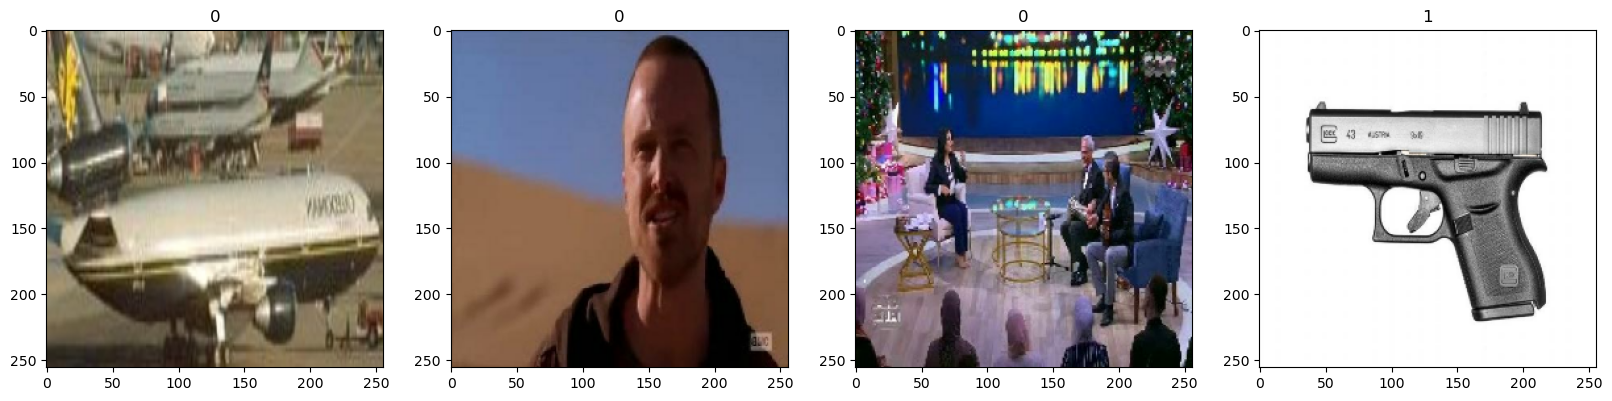

In [13]:
#indexer les images 0 pour 'non_violence' et 1 pour 'violence'
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.30392158, 0.2647059 , 0.06666667],
          [0.29142156, 0.25612745, 0.03897059],
          [0.34779412, 0.3125    , 0.08308823],
          ...,
          [0.23627451, 0.2009804 , 0.08529412],
          [0.23921569, 0.20392157, 0.07647059],
          [0.23553921, 0.2002451 , 0.07083333]],
 
         [[0.33382353, 0.297549  , 0.08946078],
          [0.30563724, 0.27328432, 0.04877451],
          [0.29852942, 0.26617646, 0.03529412],
          ...,
          [0.22647059, 0.19117647, 0.0754902 ],
          [0.24313726, 0.20784314, 0.08039216],
          [0.22156863, 0.18627451, 0.05686275]],
 
         [[0.3110294 , 0.28357843, 0.06789216],
          [0.30661765, 0.28308824, 0.05514706],
          [0.27720588, 0.25367647, 0.02426471],
          ...,
          [0.23382352, 0.1985294 , 0.08284314],
          [0.23921569, 0.20392157, 0.07647059],
          [0.23235294, 0.19705883, 0.06764706]],
 
         ...,
 
         [[0.70416665, 0.49632353, 0.3257353 ],
          [0.71348

In [16]:
len(data)

525

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size + val_size + test_size

524

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [20]:
from tensorflow.keras.models import Sequential  #sequential => ensemble des couches (pile linéaire des couches .
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #couche de convolution avec 16 filtres de taille 3*3 , fonction d'activation Relu et l'input est une image de taille 256*256 RGB
model.add(MaxPooling2D()) #reduit la taille de la sortie de couche précedente 
model.add(Conv2D(32, (3,3), 1, activation='relu')) # ajout d'une autre couche de convolution avec 32 filtre
model.add(MaxPooling2D())#encore une couche de max pooling
model.add(Conv2D(16, (3,3), 1, activation='relu'))#Une autre couche de convolution avec 16 filtres
model.add(MaxPooling2D())#encore une couche de max pooling
model.add(Flatten())# flatten  aplatit la sortie des couches précédentes en un vecteur unidimensionnel
model.add(Dense(256, activation='relu'))#Cette ligne ajoute une couche dense (entièrement connectée) avec 256 neurones et une fonction d'activation ReLU.
model.add(Dense(1, activation='sigmoid'))#La dernière couche dense avec un seul neurone et une fonction d'activation sigmoïde. Dans un problème de classification binaire, cette dernière couche produit une sortie entre 0 et 1, représentant la probabilité que l'entrée appartienne à la classe positive

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback]) #En résumé, cette ligne entraîne le modèle sur les données d'entraînement pour un certain nombre d'époques, tout en évaluant sa performance sur les données de validation. Les journaux d'entraînement sont enregistrés dans un répertoire spécifié pour une visualisation ultérieure à l'aide de TensorBoard.


Epoch 1/20
367/367 [==============================] - 135s 365ms/step - loss: 0.4301 - accuracy: 0.7995 - val_loss: 0.2151 - val_accuracy: 0.9140
Epoch 2/20
367/367 [==============================] - 124s 338ms/step - loss: 0.1560 - accuracy: 0.9411 - val_loss: 0.1536 - val_accuracy: 0.9449
Epoch 3/20
367/367 [==============================] - 121s 330ms/step - loss: 0.0704 - accuracy: 0.9757 - val_loss: 0.1739 - val_accuracy: 0.9429
Epoch 4/20
367/367 [==============================] - 123s 335ms/step - loss: 0.0285 - accuracy: 0.9911 - val_loss: 0.2187 - val_accuracy: 0.9408
Epoch 5/20
367/367 [==============================] - 124s 337ms/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.1888 - val_accuracy: 0.9557
Epoch 6/20
367/367 [==============================] - 124s 338ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 0.2226 - val_accuracy: 0.9548
Epoch 7/20
367/367 [==============================] - 134s 364ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.2383 -

In [26]:
hist.history


{'loss': [0.43012821674346924,
  0.15603996813297272,
  0.07041144371032715,
  0.028499208390712738,
  0.013353190384805202,
  0.011344775557518005,
  0.017883777618408203,
  0.009548946283757687,
  0.006047436036169529,
  0.00019531913858372718,
  4.997623182134703e-05,
  3.0301282095024362e-05,
  2.1379755708039738e-05,
  1.5737739886390045e-05,
  1.2127898116887081e-05,
  9.218605555361137e-06,
  7.2007596827461384e-06,
  5.648260867019417e-06,
  4.535705556918401e-06,
  3.559236347427941e-06],
 'accuracy': [0.7994720935821533,
  0.9410762786865234,
  0.9757322669029236,
  0.9910592436790466,
  0.9957424998283386,
  0.9966791272163391,
  0.9945504069328308,
  0.9977861046791077,
  0.9982969760894775,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.21506787836551666,
  0.15363512933254242,
  0.17388556897640228,
  0.21868592500686646,
  0.18880100548267365,
  0.22256585955619812,
  0.23834262788295746,
  0.2859375774860382,
  0.2846477031

In [1]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend
(loc="upper left")
plt.show()

SyntaxError: invalid syntax (382247379.py, line 6)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 85ms/step


In [1]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

NameError: name 'pre' is not defined

In [2]:
import cv2

In [3]:
img = cv2.imread('carvelo.jpg')
plt.imshow(img)
plt.show()

NameError: name 'plt' is not defined

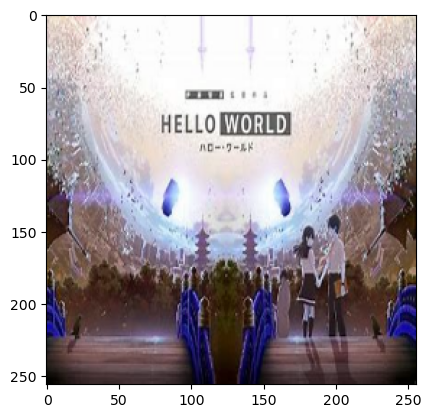

In [92]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [93]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 23ms/step


In [94]:
yhat

array([[0.00399331]], dtype=float32)

In [95]:
if yhat > 0.5: 
    print(f'Predicted class is violence')
else:
    print(f'Predicted class is non_violence')

Predicted class is non_violence


In [86]:
from tensorflow.keras.models import load_model

In [87]:
model.save(os.path.join('models','imageclassifier.h5'))

In [88]:
new_model = load_model('models/imageclassifier.h5')

In [89]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 63ms/step


In [90]:
if yhatnew > 0.5: 
    print(f'Predicted class is violence')
else:
    print(f'Predicted class is non_violence')

Predicted class is violence
